In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

import os
from os import listdir
from os.path import isfile, join

#для случайного леса
from sklearn.ensemble import RandomForestRegressor

#для оценки
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

import copy

import seaborn as sns

#для визуализации времени работы
from tqdm import tqdm, trange

import requests

import json

from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Обработка данных

In [3]:
directory = '/content/drive/MyDrive/НИР/factor'
dfs = []

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)

        # Читаем первую строку для проверки разделителя
        with open(file_path, 'r', encoding='utf-8') as f:
            header = f.readline().strip()

        # Если в заголовке есть точка с запятой, используем её как разделитель
        delimiter = ';' if ';' in header else ','

        try:
            df = pd.read_csv(file_path, delimiter=delimiter, encoding='utf-8')
            dfs.append(df)
        except Exception as e:
            print(f"Ошибка при чтении файла {filename}: {e}")

if dfs:
    result = pd.concat(dfs, join='outer')
    result = result.groupby(['oktmo', 'year', 'name']).first().reset_index()
    result['year'] = result['year'].astype(int)
    result['oktmo'] = result['oktmo'].astype(int)
    result = result.drop_duplicates().sort_values(by=['oktmo', 'year'])
    result = result.drop_duplicates().sort_values(by=['name', 'year'])
else:
    print("Не найдено CSV файлов для объединения")

In [4]:
# подгружаем целевую переменную
data = pd.read_csv('/content/drive/MyDrive/НИР/ydel_saldo.csv', header=0, sep=',', quotechar='"')
data = data[['oktmo','year', 'ydel_saldo']]
data

,oktmo,year,ydel_saldo
0,27606000,2008,-0.014543
1,27615000,2008,0.006663
2,27633000,2008,0.019869
3,27701000,2008,0.002566
4,27705000,2008,0.006925
...,...,...,...
25799,99610000,2022,-0.017899
25800,99620000,2022,-0.005605
25801,99625000,2022,-0.018405
25802,99630000,2022,-0.001336


In [5]:
result = pd.merge(result, data, on=['oktmo', 'year'], how='left')
result=result.dropna(subset=['ydel_saldo'])
result = result[result['oktmo'] % 1000 == 0]
result

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,hospitals,litstreetslen,library,roadslen,popsize,sportsvenue,shoparea,schoolnum,wholestreetslen,ydel_saldo
2081,44607000,2010,ND,NaN,13.0,10.4,NaN,91.2,NaN,256.0,...,NaN,3.9,7.0,53.0,2573.0,13.0,NaN,5.0,14.32,-0.073905
2435,32613000,2011,ND,NaN,8.0,4.2,NaN,135.0,10.0,1138.0,...,NaN,43.2,25.0,40.6,23731.0,68.0,7825.0,18.0,315.60,-0.023189
2466,44607000,2011,ND,NaN,11.0,NaN,NaN,147.0,NaN,192.0,...,NaN,3.9,7.0,53.0,2644.0,13.0,1107.6,5.0,14.32,-0.102177
2490,53603000,2011,ND,NaN,77.0,6.3,NaN,510.0,NaN,715.0,...,NaN,199.6,29.0,164.3,30445.0,117.0,12500.0,22.0,314.40,-0.041575
2492,53614000,2011,ND,NaN,1.0,2.7,NaN,100.0,NaN,559.0,...,NaN,126.2,17.0,NaN,10258.0,48.0,1406.4,18.0,191.34,-0.040953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396937,70702000,2018,рабочий поселок Новогуровский,7346488.7,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,10.1,NaN,15.2,3460.0,6.0,1690.3,NaN,10.10,-0.017838
396938,70702000,2019,рабочий поселок Новогуровский,7943246.2,NaN,NaN,NaN,NaN,NaN,178.0,...,0.0,10.1,NaN,NaN,3401.0,6.0,1690.3,NaN,10.10,0.016093
396939,70702000,2020,рабочий поселок Новогуровский,7978877.3,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,10.1,NaN,15.2,3403.0,6.0,1690.3,NaN,10.10,-0.004338
396940,70702000,2021,рабочий поселок Новогуровский,8646582.3,NaN,NaN,NaN,NaN,NaN,155.0,...,1.0,10.1,NaN,15.2,3342.0,6.0,1690.3,NaN,10.10,0.018142


In [6]:
avgsaldiff = pd.read_csv('/content/drive/MyDrive/НИР/avgsaldiff (allmun).csv', header=0, sep=',', quotechar='"')
avgsaldiff= avgsaldiff[['oktmo','year', 'avgsaldiff']]
avgsaldiff['year'] = avgsaldiff['year'].astype(int)
avgsaldiff['oktmo'] = avgsaldiff['oktmo'].astype(int)
avgsaldiff
result = pd.merge(result, avgsaldiff, on=['oktmo', 'year'], how='left')

In [7]:
# prompt: сохрани в csv result

#result.to_csv('result для данила.csv', index=False)

In [8]:
nad=result[(result.year ==2022)&(result['name'] == 'Пронский муниципальный район')]
nad[['avgsalary', 'popsize']]

,avgsalary,popsize
15298,41693.9,30269.0


In [9]:
nad.columns

Index(['oktmo', 'year', 'name', 'factoriescap', 'docsnum', 'consnewapt',
       'circuses', 'cliniccap', 'cinemas', 'beforeschool', 'hospitalcap',
       'harvest', 'goodcompincome', 'goodcompanies', 'funds',
       'foodservturnover', 'foodseats', 'fallinghousesdwellers',
       'naturesecure', 'museums', 'musartschool', 'munipoliceworkers',
       'livestock', 'livarea', 'invest', 'retailturnover',
       'poorhousesdwellers', 'pollutionvol', 'pollutcapturedperc', 'parks',
       'theatres', 'sportschool', 'socialaidhomeservices',
       'socialaidcenterscap', 'socialaidcenters', 'servicesnum',
       'badcompanies', 'avgsalary', 'avgemployers', 'agrprod', 'zoos',
       'visiblecompanies', 'budincome', 'cultureorg', 'consnewareas',
       'hospitals', 'litstreetslen', 'library', 'roadslen', 'popsize',
       'sportsvenue', 'shoparea', 'schoolnum', 'wholestreetslen', 'ydel_saldo',
       'avgsaldiff'],
      dtype='object')

In [10]:
# в данных присудствовали разные oktmo c одинаковыми названиями, с помощью этой таблицы избавляемся от этого
Error = pd.read_csv('/content/drive/MyDrive/НИР/unique_oktmo_df.csv', delimiter=';')
Error.head()

,oktmo,name
0,32613000,Ленинск-Кузнецкий муниципальный район (г Ленин...
1,44607000,Северо-Эвенский муниципаль-ный район
2,53603000,Абдулинский муниципальный район (г Абдулино)
3,53614000,Гайский муниципальный район (Аннулированный)
4,53624000,Кувандыкский муниципальный район (Аннулированный)


In [11]:
merged_df = pd.merge(result, Error, on='oktmo', how='left', suffixes=('_result', '_error'))
merged_df.loc[~merged_df['name_error'].isna(), 'name_result'] = merged_df.loc[~merged_df['name_error'].isna(), 'name_error']
result = merged_df.drop(['name_error'], axis=1)
result = result.rename(columns={'name_result': 'name'})

result

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,litstreetslen,library,roadslen,popsize,sportsvenue,shoparea,schoolnum,wholestreetslen,ydel_saldo,avgsaldiff
0,44607000,2010,Северо-Эвенский муниципаль-ный район,NaN,13.0,10.4,NaN,91.2,NaN,256.0,...,3.9,7.0,53.0,2573.0,13.0,NaN,5.0,14.32,-0.073905,NaN
1,32613000,2011,Ленинск-Кузнецкий муниципальный район (г Ленин...,NaN,8.0,4.2,NaN,135.0,10.0,1138.0,...,43.2,25.0,40.6,23731.0,68.0,7825.0,18.0,315.60,-0.023189,NaN
2,44607000,2011,Северо-Эвенский муниципаль-ный район,NaN,11.0,NaN,NaN,147.0,NaN,192.0,...,3.9,7.0,53.0,2644.0,13.0,1107.6,5.0,14.32,-0.102177,NaN
3,53603000,2011,Абдулинский муниципальный район (г Абдулино),NaN,77.0,6.3,NaN,510.0,NaN,715.0,...,199.6,29.0,164.3,30445.0,117.0,12500.0,22.0,314.40,-0.041575,NaN
4,53614000,2011,Гайский муниципальный район (Аннулированный),NaN,1.0,2.7,NaN,100.0,NaN,559.0,...,126.2,17.0,NaN,10258.0,48.0,1406.4,18.0,191.34,-0.040953,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25088,70702000,2018,рабочий поселок Новогуровский,7346488.7,NaN,NaN,NaN,NaN,NaN,NaN,...,10.1,NaN,15.2,3460.0,6.0,1690.3,NaN,10.10,-0.017838,NaN
25089,70702000,2019,рабочий поселок Новогуровский,7943246.2,NaN,NaN,NaN,NaN,NaN,178.0,...,10.1,NaN,NaN,3401.0,6.0,1690.3,NaN,10.10,0.016093,NaN
25090,70702000,2020,рабочий поселок Новогуровский,7978877.3,NaN,NaN,NaN,NaN,NaN,NaN,...,10.1,NaN,15.2,3403.0,6.0,1690.3,NaN,10.10,-0.004338,NaN
25091,70702000,2021,рабочий поселок Новогуровский,8646582.3,NaN,NaN,NaN,NaN,NaN,155.0,...,10.1,NaN,15.2,3342.0,6.0,1690.3,NaN,10.10,0.018142,NaN


In [12]:
# проверка
duplicates = result[result.duplicated(subset=['name', 'year'], keep=False)]
duplicates.name.unique().tolist()

[]

In [13]:
def zero_oktmo(oktmo):
    oktmo_str = str(oktmo)
    if len(oktmo_str) == 7:
        return "0" + oktmo_str
    return oktmo_str

result['oktmo'] = result['oktmo'].apply(zero_oktmo)

In [14]:
result

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,litstreetslen,library,roadslen,popsize,sportsvenue,shoparea,schoolnum,wholestreetslen,ydel_saldo,avgsaldiff
0,44607000,2010,Северо-Эвенский муниципаль-ный район,NaN,13.0,10.4,NaN,91.2,NaN,256.0,...,3.9,7.0,53.0,2573.0,13.0,NaN,5.0,14.32,-0.073905,NaN
1,32613000,2011,Ленинск-Кузнецкий муниципальный район (г Ленин...,NaN,8.0,4.2,NaN,135.0,10.0,1138.0,...,43.2,25.0,40.6,23731.0,68.0,7825.0,18.0,315.60,-0.023189,NaN
2,44607000,2011,Северо-Эвенский муниципаль-ный район,NaN,11.0,NaN,NaN,147.0,NaN,192.0,...,3.9,7.0,53.0,2644.0,13.0,1107.6,5.0,14.32,-0.102177,NaN
3,53603000,2011,Абдулинский муниципальный район (г Абдулино),NaN,77.0,6.3,NaN,510.0,NaN,715.0,...,199.6,29.0,164.3,30445.0,117.0,12500.0,22.0,314.40,-0.041575,NaN
4,53614000,2011,Гайский муниципальный район (Аннулированный),NaN,1.0,2.7,NaN,100.0,NaN,559.0,...,126.2,17.0,NaN,10258.0,48.0,1406.4,18.0,191.34,-0.040953,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25088,70702000,2018,рабочий поселок Новогуровский,7346488.7,NaN,NaN,NaN,NaN,NaN,NaN,...,10.1,NaN,15.2,3460.0,6.0,1690.3,NaN,10.10,-0.017838,NaN
25089,70702000,2019,рабочий поселок Новогуровский,7943246.2,NaN,NaN,NaN,NaN,NaN,178.0,...,10.1,NaN,NaN,3401.0,6.0,1690.3,NaN,10.10,0.016093,NaN
25090,70702000,2020,рабочий поселок Новогуровский,7978877.3,NaN,NaN,NaN,NaN,NaN,NaN,...,10.1,NaN,15.2,3403.0,6.0,1690.3,NaN,10.10,-0.004338,NaN
25091,70702000,2021,рабочий поселок Новогуровский,8646582.3,NaN,NaN,NaN,NaN,NaN,155.0,...,10.1,NaN,15.2,3342.0,6.0,1690.3,NaN,10.10,0.018142,NaN


In [15]:
result.columns

Index(['oktmo', 'year', 'name', 'factoriescap', 'docsnum', 'consnewapt',
       'circuses', 'cliniccap', 'cinemas', 'beforeschool', 'hospitalcap',
       'harvest', 'goodcompincome', 'goodcompanies', 'funds',
       'foodservturnover', 'foodseats', 'fallinghousesdwellers',
       'naturesecure', 'museums', 'musartschool', 'munipoliceworkers',
       'livestock', 'livarea', 'invest', 'retailturnover',
       'poorhousesdwellers', 'pollutionvol', 'pollutcapturedperc', 'parks',
       'theatres', 'sportschool', 'socialaidhomeservices',
       'socialaidcenterscap', 'socialaidcenters', 'servicesnum',
       'badcompanies', 'avgsalary', 'avgemployers', 'agrprod', 'zoos',
       'visiblecompanies', 'budincome', 'cultureorg', 'consnewareas',
       'hospitals', 'litstreetslen', 'library', 'roadslen', 'popsize',
       'sportsvenue', 'shoparea', 'schoolnum', 'wholestreetslen', 'ydel_saldo',
       'avgsaldiff'],
      dtype='object')

In [16]:
result_copy = copy.deepcopy(result)

In [17]:
replacements = {
    "Город Буденновск (до 2015 года)": "Буденновский муниципальный округ",

    "Благодарненский городской округ (с 2018 года)": "Благодарненский муниципальный район",
    "Изобильненский городской округ (с 2018 года)": "Изобильненский муниципальный район",
    "Ипатовский городской округ (с 2018 года)": "Ипатовский муниципальный район",
    "Кировский городской округ (с 2018 года)": "Кировский муниципальный район",
    "Минераловодский городской округ (с 2017 года)": "Минераловодский муниципальный район",
    "Нефтекумский городской округ (с 2018 года)": "Нефтекумский муниципальный район",
    "Новоалександровский городской округ (с 2018 года)": "Новоалександровский муниципальный район",
    "Петровский городской округ (с 2018 года)": "Петровский муниципальный район",
    "Советский городской округ (с 2018 года)": "муниципальный округ округ Петровский",

    "Выксунский муниципальный район (с 2012 г. городской округ г.Выкса)": "город Выкса",
    "Кулебакский муниципальный район (с 2016 г. городской округ г. Кулебаки)": "город Кулебаки",
    "Навашинский муниципальный район (с 2016 г. городской округ Навашинский)": "Навашинский",
    "Перевозский муниципальный район (с 2017 г. городской округ Перевозский)": "Перевозский",
    "Шахунский муниципальный район (с 2013 г. городской округ г.Шахунья)": "город Шахунья",
    "Аларский район ( до 2014 года)": "Аларский муниципальный район",
    "Баяндаевский район ( до 2014 года)": "Баяндаевский муниципальный район",
    "Боханский район ( до 2014 года)": "Боханский муниципальный район",
    "Нукутский район ( до 2014 года)": "Нукутский муниципальный район",

    "Андреапольский муниципальный район (с 2020 г. преобразован в Андреапольский муниципальный округ)": "Андреапольский",
    "Весьегонский муниципальный район (с 2020 г. преобразован в Весьегонский муниципальный округ)": "Весьегонский",
    "Западнодвинский муниципальный район (с 2021 г. преобразован в Западнодвинский муниципальный округ)": "Западнодвинский",
    "Краснохолмский муниципальный район (с 2021 г. преобразован в Краснохолмский муниципальный округ)": "Краснохолмский",
    "Лесной муниципальный район (с 2021 г. преобразован в Лесной муниципальный округ)": "Лесной",
    "Лихославльский муниципальный район (с 2022 г. преобразован в Лихославльский муниципальный округ)": "Лихославльский",
    "Молоковский муниципальный район (с 2022 г. преобразован в Молоковский муниципальный округ)": "Молоковский",
    "Оленинский муниципальный район (с 2021 г. преобразован в Оленинский муниципальный округ)": "Оленинский",
    "Пеновский муниципальный район (с 2021 г. преобразован в Пеновский муниципальный округ)": "Пеновский",
    "Рамешковский муниципальный район (с 2022 г. преобразован в Рамешковский муниципальный округ)": "Рамешковский",
    "Сандовский муниципальный район (с 2021 г. преобразован в Сандовский муниципальный округ)": "Сандовский",
    "Спировский муниципальный район (с 2022 г. преобразован в Спировский муниципальный округ)": "Спировский",
    "Кимрский муниципальный район (с 2023 г. объединен с городским округом г.Кимры и преобразован в Кимрский муниципальный округ)": "Кимрский муниципальный район",
    "Город Кимры (с 2023 г. объединен с Кимрским муниципальным районом и преобразован в Кимрский муниципальный округ)": "Кимрский муниципальный район",
    "Ржевский муниципальный район (с 2023 г. объединен с городским округом г.Ржев и преобразован в Ржевский муниципальный округ)": "Ржевский муниципальный район",
    "Город Ржев (с 2023 г. объединен с Ржевским муниципальным районом и преобразован в Ржевский муниципальный округ)": "Ржевский муниципальный район",

    "Волоколамский (до 2020 г.)": "Волоколамский",
    "Зарайский (до 2020 г.)": "Зарайск",
    "Ленинский (до 2021 г.)": "Ленинский",
    "Одинцовский (до 2020 г.)": "Одинцовский",
    "Подольский (до 2016 г.)": "Подольск",
    "Раменский (до 2020 г.)": "Раменский",
    "Рузский (до 2018 г.)": "Рузский",
    "Солнечногорский (до 2020 г.)": "Солнечногорск",
    "Талдомский (до 2019 г.)": "Талдомский",

    "Город Балей (по 2011 г. включительно)": "Балейский муниципальный район",
    "Дульдургинский муниципальный район (по 2011 г. включительно)": "Дульдургинский муниципальный район",
    "Могойтуйский муниципальный район (по 2011 г. включительно)": "Могойтуйский муниципальный район",

    "Провиденский муниципальный район (до 2016г.)": "Провиденский",

    "Муниципальный район Вуктыл (до 1 января 2017 года)": "Вуктыл",

    "Надымский муниципальный район": "Муниципальный округ Надымский район",

    "Красноселькупский муниципальный район": "Муниципальный округ Красноселькупский район",

    'Надымский муниципальный район':'Муниципальный округ Надымский район',
    'Приуральский муниципальный район':'Муниципальный округ Приуральский район',
    'Пуровский муниципальный район':'Муниципальный округ Пуровский район',
    'Тазовский муниципальный район': 'Муниципальный округ Тазовский район',
    'Ямальский муниципальный район': 'Муниципальный округ Ямальский район'

}


for old_value, new_value in replacements.items():
    result_copy['name'] = result_copy['name'].replace(old_value, new_value)

result_copy

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,litstreetslen,library,roadslen,popsize,sportsvenue,shoparea,schoolnum,wholestreetslen,ydel_saldo,avgsaldiff
0,44607000,2010,Северо-Эвенский муниципаль-ный район,NaN,13.0,10.4,NaN,91.2,NaN,256.0,...,3.9,7.0,53.0,2573.0,13.0,NaN,5.0,14.32,-0.073905,NaN
1,32613000,2011,Ленинск-Кузнецкий муниципальный район (г Ленин...,NaN,8.0,4.2,NaN,135.0,10.0,1138.0,...,43.2,25.0,40.6,23731.0,68.0,7825.0,18.0,315.60,-0.023189,NaN
2,44607000,2011,Северо-Эвенский муниципаль-ный район,NaN,11.0,NaN,NaN,147.0,NaN,192.0,...,3.9,7.0,53.0,2644.0,13.0,1107.6,5.0,14.32,-0.102177,NaN
3,53603000,2011,Абдулинский муниципальный район (г Абдулино),NaN,77.0,6.3,NaN,510.0,NaN,715.0,...,199.6,29.0,164.3,30445.0,117.0,12500.0,22.0,314.40,-0.041575,NaN
4,53614000,2011,Гайский муниципальный район (Аннулированный),NaN,1.0,2.7,NaN,100.0,NaN,559.0,...,126.2,17.0,NaN,10258.0,48.0,1406.4,18.0,191.34,-0.040953,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25088,70702000,2018,рабочий поселок Новогуровский,7346488.7,NaN,NaN,NaN,NaN,NaN,NaN,...,10.1,NaN,15.2,3460.0,6.0,1690.3,NaN,10.10,-0.017838,NaN
25089,70702000,2019,рабочий поселок Новогуровский,7943246.2,NaN,NaN,NaN,NaN,NaN,178.0,...,10.1,NaN,NaN,3401.0,6.0,1690.3,NaN,10.10,0.016093,NaN
25090,70702000,2020,рабочий поселок Новогуровский,7978877.3,NaN,NaN,NaN,NaN,NaN,NaN,...,10.1,NaN,15.2,3403.0,6.0,1690.3,NaN,10.10,-0.004338,NaN
25091,70702000,2021,рабочий поселок Новогуровский,8646582.3,NaN,NaN,NaN,NaN,NaN,155.0,...,10.1,NaN,15.2,3342.0,6.0,1690.3,NaN,10.10,0.018142,NaN


In [18]:
#если собвподает название но отличается oktmo, оставляем oktmo по последнему году
latest_oktmo = {}

for index, row in result_copy.iterrows():
    name = row['name']
    year = row['year']
    oktmo = row['oktmo']

    if name not in latest_oktmo or year > latest_oktmo[name]['year']:
        latest_oktmo[name] = {'year': year, 'oktmo': oktmo}

for index, row in result_copy.iterrows():
    result_copy.loc[index, 'oktmo'] = latest_oktmo[row['name']]['oktmo']

In [19]:
ipc = pd.read_csv('/content/drive/MyDrive/НИР/IPC2.csv', delimiter=';', encoding='utf-8')
ipc= ipc.melt(id_vars='region_naz', var_name='year', value_name='ipc')
oktmo = pd.read_csv('/content/drive/MyDrive/НИР/oktmo.csv', delimiter=';')
oktmo['region_naz'] = oktmo['region_naz'].replace('Чувашская Республика - Чувашия', 'Чувашская Республика')

In [20]:
oktmo['oktmo'] = oktmo['oktmo'].apply(zero_oktmo)

In [21]:
IPC= pd.merge(ipc, oktmo, on=['region_naz'], how='left')
IPC = IPC.dropna(subset=['oktmo'])
#IPC['oktmo'] = pd.to_numeric(IPC['oktmo'], errors='coerce').astype('Int64')
IPC['year'] = pd.to_numeric(IPC['year'], errors='coerce').astype('Int64')
IPC['ipc'] = IPC['ipc'].astype(float)
# если не '718', '719', выводит 3 цыфры, иначе 2
def extract_oktmo_prefix(oktmo):
  oktmo_str = str(oktmo)
  if oktmo_str.startswith(('718', '719')):
    return oktmo_str[:3]
  else:
    return oktmo_str[:2]

result_copy['oktmo_two'] = result_copy['oktmo'].apply(extract_oktmo_prefix)
IPC['oktmo_two'] = IPC['oktmo'].apply(extract_oktmo_prefix)

IPC = IPC[['oktmo_two','year', 'ipc' ]]
IPC

,oktmo_two,year,ipc
2,14,1992,2601.89
3,15,1992,1758.77
4,17,1992,2349.35
5,20,1992,2584.68
6,24,1992,2780.90
...,...,...,...
2971,10,2023,108.30
2972,44,2023,106.41
2973,64,2023,107.44
2974,99,2023,107.97


In [22]:
result_IPC= result_copy.merge(IPC, on=['oktmo_two', 'year'], how='left')
result_IPC

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,roadslen,popsize,sportsvenue,shoparea,schoolnum,wholestreetslen,ydel_saldo,avgsaldiff,oktmo_two,ipc
0,44607000,2010,Северо-Эвенский муниципаль-ный район,NaN,13.0,10.4,NaN,91.2,NaN,256.0,...,53.0,2573.0,13.0,NaN,5.0,14.32,-0.073905,NaN,44,108.54
1,32613000,2011,Ленинск-Кузнецкий муниципальный район (г Ленин...,NaN,8.0,4.2,NaN,135.0,10.0,1138.0,...,40.6,23731.0,68.0,7825.0,18.0,315.60,-0.023189,NaN,32,106.47
2,44607000,2011,Северо-Эвенский муниципаль-ный район,NaN,11.0,NaN,NaN,147.0,NaN,192.0,...,53.0,2644.0,13.0,1107.6,5.0,14.32,-0.102177,NaN,44,109.22
3,53603000,2011,Абдулинский муниципальный район (г Абдулино),NaN,77.0,6.3,NaN,510.0,NaN,715.0,...,164.3,30445.0,117.0,12500.0,22.0,314.40,-0.041575,NaN,53,105.68
4,53614000,2011,Гайский муниципальный район (Аннулированный),NaN,1.0,2.7,NaN,100.0,NaN,559.0,...,NaN,10258.0,48.0,1406.4,18.0,191.34,-0.040953,NaN,53,105.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25088,70702000,2018,рабочий поселок Новогуровский,7346488.7,NaN,NaN,NaN,NaN,NaN,NaN,...,15.2,3460.0,6.0,1690.3,NaN,10.10,-0.017838,NaN,70,104.71
25089,70702000,2019,рабочий поселок Новогуровский,7943246.2,NaN,NaN,NaN,NaN,NaN,178.0,...,NaN,3401.0,6.0,1690.3,NaN,10.10,0.016093,NaN,70,102.10
25090,70702000,2020,рабочий поселок Новогуровский,7978877.3,NaN,NaN,NaN,NaN,NaN,NaN,...,15.2,3403.0,6.0,1690.3,NaN,10.10,-0.004338,NaN,70,106.10
25091,70702000,2021,рабочий поселок Новогуровский,8646582.3,NaN,NaN,NaN,NaN,NaN,155.0,...,15.2,3342.0,6.0,1690.3,NaN,10.10,0.018142,NaN,70,108.70


In [23]:
result_IPC[result_IPC['ipc'].isnull()]

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,roadslen,popsize,sportsvenue,shoparea,schoolnum,wholestreetslen,ydel_saldo,avgsaldiff,oktmo_two,ipc


In [24]:
# удалим NaN в ipc так как то oktmo которое начинается на '16', '55', '11', '71', '97' , насамом деле начинается на 016... и это муниципальные районы и тд
#result_IPC = result_IPC.dropna(subset=['ipc'])
result_IPC = result_IPC.drop(columns=['oktmo_two']) # удалим из-за ненадобности в дальнейшем
result_IPC

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,library,roadslen,popsize,sportsvenue,shoparea,schoolnum,wholestreetslen,ydel_saldo,avgsaldiff,ipc
0,44607000,2010,Северо-Эвенский муниципаль-ный район,NaN,13.0,10.4,NaN,91.2,NaN,256.0,...,7.0,53.0,2573.0,13.0,NaN,5.0,14.32,-0.073905,NaN,108.54
1,32613000,2011,Ленинск-Кузнецкий муниципальный район (г Ленин...,NaN,8.0,4.2,NaN,135.0,10.0,1138.0,...,25.0,40.6,23731.0,68.0,7825.0,18.0,315.60,-0.023189,NaN,106.47
2,44607000,2011,Северо-Эвенский муниципаль-ный район,NaN,11.0,NaN,NaN,147.0,NaN,192.0,...,7.0,53.0,2644.0,13.0,1107.6,5.0,14.32,-0.102177,NaN,109.22
3,53603000,2011,Абдулинский муниципальный район (г Абдулино),NaN,77.0,6.3,NaN,510.0,NaN,715.0,...,29.0,164.3,30445.0,117.0,12500.0,22.0,314.40,-0.041575,NaN,105.68
4,53614000,2011,Гайский муниципальный район (Аннулированный),NaN,1.0,2.7,NaN,100.0,NaN,559.0,...,17.0,NaN,10258.0,48.0,1406.4,18.0,191.34,-0.040953,NaN,105.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25088,70702000,2018,рабочий поселок Новогуровский,7346488.7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,15.2,3460.0,6.0,1690.3,NaN,10.10,-0.017838,NaN,104.71
25089,70702000,2019,рабочий поселок Новогуровский,7943246.2,NaN,NaN,NaN,NaN,NaN,178.0,...,NaN,NaN,3401.0,6.0,1690.3,NaN,10.10,0.016093,NaN,102.10
25090,70702000,2020,рабочий поселок Новогуровский,7978877.3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,15.2,3403.0,6.0,1690.3,NaN,10.10,-0.004338,NaN,106.10
25091,70702000,2021,рабочий поселок Новогуровский,8646582.3,NaN,NaN,NaN,NaN,NaN,155.0,...,NaN,15.2,3342.0,6.0,1690.3,NaN,10.10,0.018142,NaN,108.70


In [25]:
# Ценовые факторы
columns_to_deflate = ['agrprod', 'budincome', 'factoriescap', 'foodservturnover', 'funds',
                      'goodcompincome', 'invest', 'naturesecure', 'retailturnover', 'avgsalary']

# Итерация по годам и уменьшение значений в выбранных столбцах
for year in result_IPC['year'].unique():
    try:
        # Базовый год - 2013
        # IPC за 2013 год
        ipc_2013 = result_IPC[(result_IPC['year'] == 2013)]['ipc'].iloc[0]

        # IPC за текущий год
        ipc_current_year = result_IPC[(result_IPC['year'] == year)]['ipc'].iloc[0]

        # Вычисление коэффициента дефляции
        deflation_factor = ipc_2013 / ipc_current_year

        # Применение коэффициента к выбранным столбцам
        for col in columns_to_deflate:
            if col in result_IPC.columns:
                result_IPC.loc[result_IPC['year'] == year, col] = (
                    result_IPC.loc[result_IPC['year'] == year, col] * deflation_factor
                )
            else:
                print(f"Column '{col}' not found in the DataFrame.")
    except Exception as e:
        print(f"Error processing year {year}: {e}")

# Округление значений до целых чисел (если необходимо)
result_IPC[columns_to_deflate] = result_IPC[columns_to_deflate].round(0)

# Убедиться, что вывод чисел читаемый
pd.options.display.float_format = '{:.2f}'.format
result_IPC

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,library,roadslen,popsize,sportsvenue,shoparea,schoolnum,wholestreetslen,ydel_saldo,avgsaldiff,ipc
0,44607000,2010,Северо-Эвенский муниципаль-ный район,NaN,13.00,10.40,NaN,91.20,NaN,256.00,...,7.00,53.00,2573.00,13.00,NaN,5.00,14.32,-0.07,NaN,108.54
1,32613000,2011,Ленинск-Кузнецкий муниципальный район (г Ленин...,NaN,8.00,4.20,NaN,135.00,10.00,1138.00,...,25.00,40.60,23731.00,68.00,7825.00,18.00,315.60,-0.02,NaN,106.47
2,44607000,2011,Северо-Эвенский муниципаль-ный район,NaN,11.00,NaN,NaN,147.00,NaN,192.00,...,7.00,53.00,2644.00,13.00,1107.60,5.00,14.32,-0.10,NaN,109.22
3,53603000,2011,Абдулинский муниципальный район (г Абдулино),NaN,77.00,6.30,NaN,510.00,NaN,715.00,...,29.00,164.30,30445.00,117.00,12500.00,22.00,314.40,-0.04,NaN,105.68
4,53614000,2011,Гайский муниципальный район (Аннулированный),NaN,1.00,2.70,NaN,100.00,NaN,559.00,...,17.00,NaN,10258.00,48.00,1406.40,18.00,191.34,-0.04,NaN,105.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25088,70702000,2018,рабочий поселок Новогуровский,7380900.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,15.20,3460.00,6.00,1690.30,NaN,10.10,-0.02,NaN,104.71
25089,70702000,2019,рабочий поселок Новогуровский,8035761.00,NaN,NaN,NaN,NaN,NaN,178.00,...,NaN,NaN,3401.00,6.00,1690.30,NaN,10.10,0.02,NaN,102.10
25090,70702000,2020,рабочий поселок Новогуровский,7986476.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,15.20,3403.00,6.00,1690.30,NaN,10.10,-0.00,NaN,106.10
25091,70702000,2021,рабочий поселок Новогуровский,8369458.00,NaN,NaN,NaN,NaN,NaN,155.00,...,NaN,15.20,3342.00,6.00,1690.30,NaN,10.10,0.02,NaN,108.70


In [26]:
result_IPC=result_IPC[result_IPC.columns.drop(['ipc'])]
result=result_IPC

In [27]:
result_IPC

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,litstreetslen,library,roadslen,popsize,sportsvenue,shoparea,schoolnum,wholestreetslen,ydel_saldo,avgsaldiff
0,44607000,2010,Северо-Эвенский муниципаль-ный район,NaN,13.00,10.40,NaN,91.20,NaN,256.00,...,3.90,7.00,53.00,2573.00,13.00,NaN,5.00,14.32,-0.07,NaN
1,32613000,2011,Ленинск-Кузнецкий муниципальный район (г Ленин...,NaN,8.00,4.20,NaN,135.00,10.00,1138.00,...,43.20,25.00,40.60,23731.00,68.00,7825.00,18.00,315.60,-0.02,NaN
2,44607000,2011,Северо-Эвенский муниципаль-ный район,NaN,11.00,NaN,NaN,147.00,NaN,192.00,...,3.90,7.00,53.00,2644.00,13.00,1107.60,5.00,14.32,-0.10,NaN
3,53603000,2011,Абдулинский муниципальный район (г Абдулино),NaN,77.00,6.30,NaN,510.00,NaN,715.00,...,199.60,29.00,164.30,30445.00,117.00,12500.00,22.00,314.40,-0.04,NaN
4,53614000,2011,Гайский муниципальный район (Аннулированный),NaN,1.00,2.70,NaN,100.00,NaN,559.00,...,126.20,17.00,NaN,10258.00,48.00,1406.40,18.00,191.34,-0.04,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25088,70702000,2018,рабочий поселок Новогуровский,7380900.00,NaN,NaN,NaN,NaN,NaN,NaN,...,10.10,NaN,15.20,3460.00,6.00,1690.30,NaN,10.10,-0.02,NaN
25089,70702000,2019,рабочий поселок Новогуровский,8035761.00,NaN,NaN,NaN,NaN,NaN,178.00,...,10.10,NaN,NaN,3401.00,6.00,1690.30,NaN,10.10,0.02,NaN
25090,70702000,2020,рабочий поселок Новогуровский,7986476.00,NaN,NaN,NaN,NaN,NaN,NaN,...,10.10,NaN,15.20,3403.00,6.00,1690.30,NaN,10.10,-0.00,NaN
25091,70702000,2021,рабочий поселок Новогуровский,8369458.00,NaN,NaN,NaN,NaN,NaN,155.00,...,10.10,NaN,15.20,3342.00,6.00,1690.30,NaN,10.10,0.02,NaN


In [28]:
#result_IPC.to_csv('result_IPC.csv', index=False)

In [29]:
df=result_IPC

for col in ['agrprod', 'badcompanies', 'beforeschool', 'budincome', 'cinemas', 'circuses', 'cliniccap', 'consnewareas',
            'cultureorg', 'docsnum', 'factoriescap', 'foodseats', 'foodservturnover', 'funds', 'goodcompanies',
            'goodcompincome', 'hospitalcap', 'hospitals', 'invest', 'library', 'livestock', 'munipoliceworkers',
            'musartschool', 'museums', 'naturesecure', 'parks', 'pollutionvol', 'retailturnover', 'roadslen', 'schoolnum',
            'servicesnum', 'shoparea', 'socialaidcenters', 'socialaidcenterscap', 'socialaidhomeservices', 'sportschool',
            'sportsvenue', 'theatres', 'visiblecompanies', 'zoos']:
    # ?????
    #df[col] = df[col] * 1000
    #if df[col].mean() < 1000:
    #    df[col] = df[col] * 10000
    df[col] = df[col] / df.popsize

df['badhousesdwellers'] = (df['fallinghousesdwellers'] + df['poorhousesdwellers']) / df['popsize']
df['litstreetperc'] = df.litstreetslen / df.wholestreetslen
df = df.drop(['fallinghousesdwellers', 'poorhousesdwellers', 'litstreetslen', 'wholestreetslen'], axis = 1)

/tmp/ipython-input-1022316816.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col] / df.popsize


In [30]:
result=df

In [31]:
result

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,library,roadslen,popsize,sportsvenue,shoparea,schoolnum,ydel_saldo,avgsaldiff,badhousesdwellers,litstreetperc
0,44607000,2010,Северо-Эвенский муниципаль-ный район,NaN,0.01,10.40,NaN,0.04,NaN,0.10,...,0.00,0.02,2573.00,0.01,NaN,0.00,-0.07,NaN,0.17,0.27
1,32613000,2011,Ленинск-Кузнецкий муниципальный район (г Ленин...,NaN,0.00,4.20,NaN,0.01,0.00,0.05,...,0.00,0.00,23731.00,0.00,0.33,0.00,-0.02,NaN,NaN,0.14
2,44607000,2011,Северо-Эвенский муниципаль-ный район,NaN,0.00,NaN,NaN,0.06,NaN,0.07,...,0.00,0.02,2644.00,0.00,0.42,0.00,-0.10,NaN,0.19,0.27
3,53603000,2011,Абдулинский муниципальный район (г Абдулино),NaN,0.00,6.30,NaN,0.02,NaN,0.02,...,0.00,0.01,30445.00,0.00,0.41,0.00,-0.04,NaN,0.05,0.63
4,53614000,2011,Гайский муниципальный район (Аннулированный),NaN,0.00,2.70,NaN,0.01,NaN,0.05,...,0.00,NaN,10258.00,0.00,0.14,0.00,-0.04,NaN,0.09,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25088,70702000,2018,рабочий поселок Новогуровский,2133.21,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.00,3460.00,0.00,0.49,NaN,-0.02,NaN,NaN,1.00
25089,70702000,2019,рабочий поселок Новогуровский,2362.76,NaN,NaN,NaN,NaN,NaN,0.05,...,NaN,NaN,3401.00,0.00,0.50,NaN,0.02,NaN,NaN,1.00
25090,70702000,2020,рабочий поселок Новогуровский,2346.89,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.00,3403.00,0.00,0.50,NaN,-0.00,NaN,NaN,1.00
25091,70702000,2021,рабочий поселок Новогуровский,2504.33,NaN,NaN,NaN,NaN,NaN,0.05,...,NaN,0.00,3342.00,0.00,0.51,NaN,0.02,NaN,NaN,1.00


In [32]:
result.isnull().sum().sum() # количество пропущенных до обрезки данных

np.int64(536938)

In [33]:
result[result['name'] == 'Гатчинский муниципальный район']

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,library,roadslen,popsize,sportsvenue,shoparea,schoolnum,ydel_saldo,avgsaldiff,badhousesdwellers,litstreetperc
4118,41618000,2014,Гатчинский муниципальный район,200.38,NaN,NaN,NaN,NaN,NaN,0.03,...,0.00,0.00,244412.00,0.00,0.66,0.00,0.02,NaN,0.01,NaN
4119,41618000,2015,Гатчинский муниципальный район,223.14,NaN,NaN,NaN,NaN,NaN,0.04,...,NaN,0.00,246223.00,NaN,NaN,NaN,0.01,NaN,NaN,NaN
4120,41618000,2016,Гатчинский муниципальный район,246.73,NaN,NaN,NaN,NaN,NaN,0.04,...,0.00,0.00,245976.00,0.00,0.74,0.00,0.01,NaN,NaN,0.84
4121,41618000,2017,Гатчинский муниципальный район,266.33,NaN,NaN,NaN,NaN,NaN,0.04,...,0.00,0.00,245619.00,0.00,0.97,0.00,-0.00,NaN,NaN,0.89
4122,41618000,2018,Гатчинский муниципальный район,339.01,NaN,NaN,NaN,NaN,NaN,0.04,...,NaN,0.00,244252.00,0.00,1.04,NaN,0.00,NaN,NaN,0.88
4123,41618000,2019,Гатчинский муниципальный район,414.75,NaN,NaN,NaN,NaN,NaN,0.04,...,NaN,0.00,243156.00,0.00,1.01,NaN,-0.03,NaN,NaN,0.88
4124,41618000,2020,Гатчинский муниципальный район,472.06,NaN,NaN,NaN,NaN,NaN,0.04,...,NaN,0.00,238034.00,0.00,0.94,NaN,-0.02,NaN,NaN,0.89
4125,41618000,2021,Гатчинский муниципальный район,546.84,NaN,NaN,NaN,NaN,NaN,0.04,...,NaN,0.00,232752.00,0.00,0.94,NaN,0.00,NaN,NaN,0.89
4126,41618000,2022,Гатчинский муниципальный район,558.58,NaN,NaN,NaN,NaN,NaN,0.04,...,NaN,0.00,230324.00,0.00,0.97,NaN,0.00,0.11,NaN,0.87


In [34]:
#наблюдения где 50% данных не имеют пропусков
df_50 = result.dropna(thresh=len(result.columns) * 0.5) # Adjust 0.5 (50%) as needed

df_50.name.unique().tolist()
Null = df_50.isnull().sum().sum()

In [35]:
df_50

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,library,roadslen,popsize,sportsvenue,shoparea,schoolnum,ydel_saldo,avgsaldiff,badhousesdwellers,litstreetperc
0,44607000,2010,Северо-Эвенский муниципаль-ный район,NaN,0.01,10.40,NaN,0.04,NaN,0.10,...,0.00,0.02,2573.00,0.01,NaN,0.00,-0.07,NaN,0.17,0.27
1,32613000,2011,Ленинск-Кузнецкий муниципальный район (г Ленин...,NaN,0.00,4.20,NaN,0.01,0.00,0.05,...,0.00,0.00,23731.00,0.00,0.33,0.00,-0.02,NaN,NaN,0.14
2,44607000,2011,Северо-Эвенский муниципаль-ный район,NaN,0.00,NaN,NaN,0.06,NaN,0.07,...,0.00,0.02,2644.00,0.00,0.42,0.00,-0.10,NaN,0.19,0.27
3,53603000,2011,Абдулинский муниципальный район (г Абдулино),NaN,0.00,6.30,NaN,0.02,NaN,0.02,...,0.00,0.01,30445.00,0.00,0.41,0.00,-0.04,NaN,0.05,0.63
4,53614000,2011,Гайский муниципальный район (Аннулированный),NaN,0.00,2.70,NaN,0.01,NaN,0.05,...,0.00,NaN,10258.00,0.00,0.14,0.00,-0.04,NaN,0.09,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25080,50740000,2021,рабочий поселок Кольцово,1108.57,NaN,NaN,NaN,NaN,NaN,0.10,...,NaN,0.00,17489.00,0.00,0.49,NaN,0.01,NaN,NaN,0.38
25081,50740000,2022,рабочий поселок Кольцово,951.37,NaN,NaN,NaN,NaN,NaN,0.10,...,NaN,0.00,17599.00,0.00,0.53,NaN,0.00,0.12,NaN,0.41
25083,70702000,2013,рабочий поселок Новогуровский,NaN,NaN,NaN,NaN,NaN,NaN,0.04,...,0.00,0.00,3497.00,0.00,0.41,0.00,0.01,NaN,NaN,1.00
25084,70702000,2014,рабочий поселок Новогуровский,1481.33,NaN,NaN,NaN,NaN,NaN,0.04,...,0.00,0.00,3472.00,0.00,0.35,0.00,0.02,NaN,NaN,NaN


In [36]:
#[df_50['name'] == 'Гатчинский муниципальный район']

In [37]:
# Функция для заполнения пропущенных значений всего датасета
def fill(df):
    # Сортируем данные по 'oktmo' и 'year'
    df = df.sort_values(by=['oktmo', 'year'])

    # Заполняем пропущенные значения вперед и назад по группам
    df = df.groupby('oktmo').apply(lambda group: group.ffill().bfill()).reset_index(drop=True)
    return df

# Применяем функцию
result = fill(df_50)
Null2 = result.isnull().sum().sum()

/tmp/ipython-input-1770809827.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('oktmo').apply(lambda group: group.ffill().bfill()).reset_index(drop=True)


In [38]:
Null# количество значений где заполнено более 50 %

np.int64(415905)

In [39]:
Null2# количество значений после обработки пропущенных

np.int64(169765)

In [40]:
Null-Null2#кол-во запол.

np.int64(246140)

In [41]:
#result[result['name'] == 'Гатчинский муниципальный район']

In [42]:
#result.info()

In [43]:
result=result.drop(columns=['hospitalcap'])

In [44]:
pd.set_option("display.max_columns", None)  # Show all column
result.describe()

,year,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,harvest,goodcompincome,goodcompanies,funds,foodservturnover,foodseats,naturesecure,museums,musartschool,munipoliceworkers,livestock,livarea,invest,retailturnover,pollutionvol,pollutcapturedperc,parks,theatres,sportschool,socialaidhomeservices,socialaidcenterscap,socialaidcenters,servicesnum,badcompanies,avgsalary,avgemployers,agrprod,zoos,visiblecompanies,budincome,cultureorg,consnewareas,hospitals,library,roadslen,popsize,sportsvenue,shoparea,schoolnum,ydel_saldo,avgsaldiff,badhousesdwellers,litstreetperc
count,21324.00,21239.00,18932.00,12296.00,4705.00,18911.00,11101.00,21306.00,20935.00,20484.00,20640.00,20843.00,18810.00,21189.00,20573.00,17118.00,20188.00,8614.00,20987.00,21288.00,18978.00,20719.00,19033.00,16354.00,9094.00,5796.00,20167.00,19874.00,14963.00,17592.00,21249.00,20101.00,21262.00,21262.00,21101.00,4777.00,20997.00,21163.00,20460.00,21249.00,21203.00,20362.00,21314.00,21324.00,21324.00,21317.00,20258.00,21324.00,16177.00,15589.00,21217.00
mean,2016.50,479.43,0.00,6.53,0.00,0.02,0.00,0.05,1156342.10,72.77,0.00,2.11,1.83,0.02,2.96,0.00,0.00,0.00,485.50,30.77,98.50,40.05,0.00,31.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,31742.76,13496.84,81.05,0.00,0.00,36.77,0.00,0.40,0.00,0.00,0.02,58747.60,0.00,0.60,0.00,-0.01,0.14,0.05,0.57
std,3.35,2193.08,0.00,33.11,0.00,0.01,0.00,0.02,33126856.63,781.80,0.00,5.65,7.07,0.02,11.03,0.00,0.00,0.00,22270.50,138.74,709.26,58.78,0.01,30.52,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.08,20258.27,35125.84,104.32,0.00,0.00,43.76,0.00,1.09,0.00,0.00,0.01,125872.19,0.00,0.38,0.00,0.03,0.05,0.08,0.27
min,2008.00,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8299.00,168.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,637.00,0.00,0.00,0.00,-0.60,-0.16,0.00,0.00
25%,2014.00,45.38,0.00,1.10,0.00,0.02,0.00,0.04,8672.35,1.03,0.00,0.63,0.22,0.01,0.12,0.00,0.00,0.00,0.32,23.40,8.66,10.66,0.00,4.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20414.00,2547.00,11.96,0.00,0.00,19.31,0.00,0.13,0.00,0.00,0.01,15939.50,0.00,0.39,0.00,-0.02,0.11,0.01,0.36
50%,2016.00,128.41,0.00,2.35,0.00,0.02,0.00,0.05,19490.09,5.40,0.00,1.02,0.56,0.02,0.60,0.00,0.00,0.00,1.40,26.40,20.29,25.71,0.00,21.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,27377.00,4649.00,48.40,0.00,0.00,26.30,0.00,0.25,0.00,0.00,0.01,26283.50,0.00,0.53,0.00,-0.01,0.13,0.02,0.59
75%,2019.00,335.87,0.00,4.70,0.00,0.03,0.00,0.06,46551.95,22.99,0.00,1.80,1.45,0.03,1.91,0.00,0.00,0.00,3.94,30.70,49.65,51.12,0.00,53.60,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,36472.00,9798.00,108.61,0.00,0.00,37.71,0.00,0.46,0.00,0.00,0.02,48997.50,0.00,0.71,0.00,0.00,0.16,0.06,0.80
max,2022.00,104897.70,0.02,818.00,0.00,0.30,0.00,0.41,999999999.90,57319.42,0.00,277.47,232.99,0.36,333.78,0.00,0.00,0.01,1111318.10,12542.10,40023.18,1590.31,0.30,213.00,0.00,0.00,0.00,0.01,0.07,0.01,0.02,11.85,509372.00,453809.00,1751.44,0.00,0.00,872.86,0.01,123.67,0.00,0.01,0.17,1625631.00,0.01,18.00,0.00,2.62,0.47,1.04,1.05


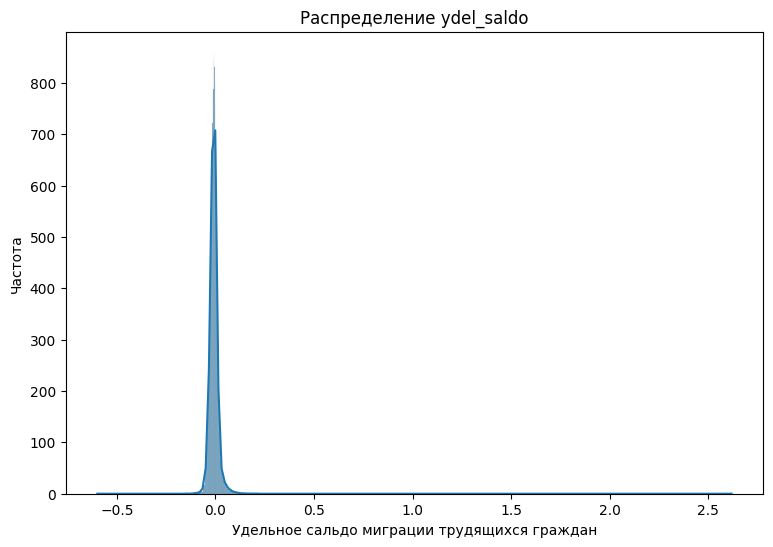

In [45]:
plt.figure(figsize=(9, 6))
sns.histplot(result['ydel_saldo'], kde=True)
plt.title('Распределение ydel_saldo')
plt.xlabel('Удельное сальдо миграции трудящихся граждан')
plt.ylabel('Частота')
plt.show()

In [46]:
len(result[(result['ydel_saldo'] >0.2) | (result['ydel_saldo'] < -0.2)])

9

In [47]:
result = result[(result['ydel_saldo'] < 0.2) & (result['ydel_saldo'] > -0.2)]
result

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,harvest,goodcompincome,goodcompanies,funds,foodservturnover,foodseats,naturesecure,museums,musartschool,munipoliceworkers,livestock,livarea,invest,retailturnover,pollutionvol,pollutcapturedperc,parks,theatres,sportschool,socialaidhomeservices,socialaidcenterscap,socialaidcenters,servicesnum,badcompanies,avgsalary,avgemployers,agrprod,zoos,visiblecompanies,budincome,cultureorg,consnewareas,hospitals,library,roadslen,popsize,sportsvenue,shoparea,schoolnum,ydel_saldo,avgsaldiff,badhousesdwellers,litstreetperc
0,01601000,2011,Алейский муниципальный район,21.01,0.00,0.86,NaN,0.01,NaN,0.03,17775.38,0.32,0.00,0.91,0.11,0.00,NaN,NaN,NaN,NaN,9.34,28.60,2.38,1.47,0.00,3.60,NaN,NaN,0.00,0.00,0.00,NaN,0.00,0.00,9851.00,1962.00,114.97,NaN,0.00,14.82,0.00,0.07,0.00,0.00,0.01,16678.00,0.00,0.30,0.00,-0.08,NaN,NaN,0.20
1,01601000,2012,Алейский муниципальный район,21.01,0.00,0.86,NaN,0.01,NaN,0.03,16702.79,2.58,0.00,0.77,0.11,0.00,NaN,NaN,NaN,NaN,9.17,25.60,2.38,11.85,0.00,3.60,NaN,NaN,0.00,0.00,0.00,NaN,0.00,0.00,10631.00,2111.00,99.33,NaN,0.00,16.04,0.00,0.09,0.00,0.00,0.02,15840.00,0.00,0.32,0.00,-0.05,NaN,NaN,0.20
2,01601000,2013,Алейский муниципальный район,21.01,0.00,0.86,NaN,0.01,NaN,0.03,16302.50,1.87,0.00,0.72,0.14,0.00,NaN,NaN,NaN,NaN,8.97,26.10,5.92,11.85,0.00,3.60,NaN,NaN,0.00,0.00,0.01,NaN,0.00,0.00,12317.00,1628.00,139.44,NaN,0.00,16.18,0.00,0.09,0.00,0.00,0.02,15374.00,0.01,0.34,0.00,-0.03,NaN,NaN,0.20
3,01601000,2014,Алейский муниципальный район,21.01,0.00,0.86,NaN,0.01,NaN,0.03,15943.68,0.73,0.00,0.61,0.21,0.00,NaN,NaN,NaN,NaN,8.61,26.60,3.78,11.85,0.00,3.60,NaN,NaN,0.00,0.00,0.01,NaN,0.00,0.00,12314.00,1755.00,114.95,NaN,0.00,12.15,0.00,0.11,0.00,0.00,0.02,15117.00,0.01,0.34,0.00,-0.03,NaN,NaN,0.20
4,01601000,2015,Алейский муниципальный район,27.96,0.00,0.86,NaN,0.01,NaN,0.03,13490.07,3.39,0.00,0.58,0.25,0.01,NaN,NaN,NaN,NaN,8.41,27.10,2.37,11.85,0.00,3.60,NaN,NaN,0.00,0.00,0.01,NaN,0.00,0.00,13222.00,1723.00,152.60,NaN,0.00,13.36,0.00,0.06,0.00,0.00,0.02,14961.00,0.01,0.32,0.00,-0.02,NaN,NaN,0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21319,99701000,2018,город Биробиджан,117.03,NaN,NaN,NaN,NaN,NaN,0.07,13370.00,1.28,0.00,1.13,1.20,0.05,1.67,0.00,0.00,NaN,0.02,23.10,52.69,85.87,0.00,83.90,NaN,0.00,0.00,0.00,0.01,0.00,0.01,0.00,42574.00,19818.00,4.91,NaN,0.00,21.59,0.00,0.19,0.00,0.00,0.00,73623.00,0.00,2.03,0.00,-0.01,0.11,NaN,0.63
21320,99701000,2019,город Биробиджан,130.95,NaN,NaN,NaN,NaN,NaN,0.07,7540.10,25.86,0.00,1.13,0.83,0.04,1.22,0.00,0.00,NaN,0.02,23.80,79.02,100.19,0.00,83.90,NaN,0.00,0.00,0.00,0.01,0.00,0.01,0.00,45957.00,19934.00,3.60,NaN,0.00,25.71,0.00,0.10,0.00,0.00,0.00,73129.00,0.00,1.84,0.00,-0.03,0.11,NaN,0.63
21321,99701000,2020,город Биробиджан,136.26,NaN,NaN,NaN,NaN,NaN,0.07,12278.00,16.21,0.00,1.09,2.36,0.04,1.26,0.00,0.00,NaN,0.01,24.90,118.98,154.23,0.00,83.90,NaN,0.00,0.00,0.00,0.01,0.00,0.01,0.00,48979.00,20014.00,5.58,NaN,0.00,33.60,0.00,0.10,0.00,0.00,0.00,71843.00,0.00,2.08,0.00,-0.02,0.11,NaN,0.63
21322,99701000,2021,город Биробиджан,147.42,NaN,NaN,NaN,NaN,NaN,0.07,13691.80,155.21,0.00,1.08,2.95,0.04,0.89,0.00,0.00,NaN,0.28,25.40,113.40,159.23,0.00,83.90,NaN,0.00,0.00,0.00,0.01,0.00,0.01,0.00,50441.00,19591.00,5.83,NaN,0.00,33.60,0.00,0.18,0.00,0.00,0.00,70433.00,0.00,2.13,0.00,-0.02,0.11,NaN,0.63


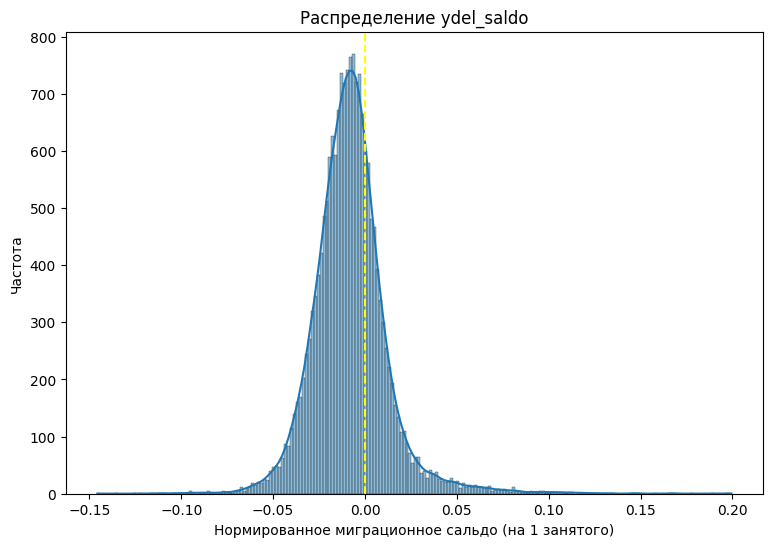

In [64]:
plt.figure(figsize=(9, 6))
sns.histplot(result['ydel_saldo'], kde=True)
plt.title('Распределение ydel_saldo')
plt.xlabel('Нормированное миграционное сальдо (на 1 занятого)')
plt.ylabel('Частота')
plt.axvline(x=0, color='yellow', linestyle='--')
plt.show()

In [49]:
# Если result[result['harvest'] >= 999999999] замени это значение значением предыдущего года

row = result[result['harvest'] >= 999999999]

group = result.groupby('oktmo')

for index, row in row.iterrows():
    oktmo = row['oktmo']
    year = row['year']

    previous_year = year - 1
    previous_year_value = group.get_group(oktmo)[group.get_group(oktmo)['year'] == previous_year]['harvest']

    if not previous_year_value.empty:
        result.loc[index, 'harvest'] = previous_year_value.iloc[0]
    else:
        print(f"No previous year data found for oktmo {oktmo} in year {previous_year}. Value not replaced.")

In [50]:
result.shape

(21315, 53)

In [51]:
result = pd.read_csv('/content/drive/MyDrive/НИР/НИР 3 сем /данные/data_for_pred.csv')

In [52]:
# Drop rows with NaN values in the 'risk' column
result.dropna(subset=['ydel_saldo'], inplace=True)

num_cols = result.select_dtypes(include="number").columns
result[num_cols] = result[num_cols].fillna(0)

## Построение модели

In [54]:
from sklearn.metrics import mean_absolute_error
feature_order = result.columns.drop(['risk','oktmo','year', 'name','popsize','ydel_saldo'])
X = result[feature_order]
Y = result[['ydel_saldo']].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = RFR(n_estimators =500, min_samples_split =2, min_samples_leaf = 1, max_features = 'sqrt', random_state=24)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")
print(f"Mean Absolute Error (MAE): {mae}")

Train score: 0.9412368207730476
Test score: 0.5921627896772697
Mean Absolute Error (MAE): 0.009008129876444993


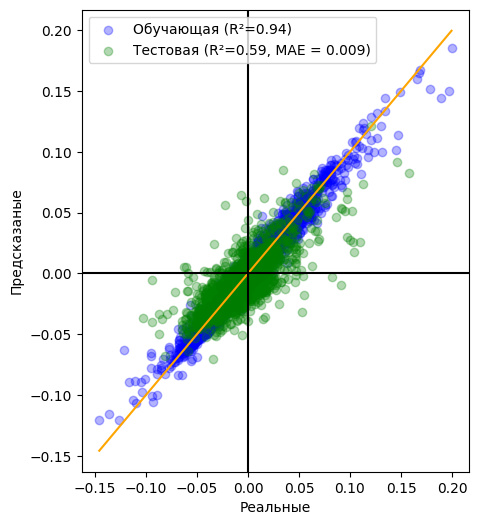

In [63]:
scale=np.linspace(y_train.min(), y_train.max(), 100)
plt.figure(figsize=(5, 6))
plt.scatter(y_train, model.predict(X_train)*1.2, c='b', alpha=.3, label=f'Обучающая (R²={train_score:.2f})')
plt.scatter(y_test, model.predict(X_test)*1.2, c='g', alpha=.3, label=f'Тестовая (R²={test_score:.2f}, MAE = {mae:.3f})')
plt.plot(scale, scale, c='orange')
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.xlabel('Реальные')
plt.ylabel('Предсказаные')
plt.legend()
plt.show()

In [ ]:
import os, re
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor as RFR


# -----------------------------
# 0) Настройки
# -----------------------------
DATA_PATH = '/content/drive/MyDrive/НИР/НИР 3 сем /данные/data_for_pred.csv'
RECOM_FOLDER = "/content"
IMPROVE_YEAR = 2021  # <-- фиксируем год улучшений


# -----------------------------
# 1) Данные
# -----------------------------
result = pd.read_csv(DATA_PATH)

# target
result.dropna(subset=['ydel_saldo'], inplace=True)

# fill numeric NaNs with 0
num_cols = result.select_dtypes(include="number").columns
result[num_cols] = result[num_cols].fillna(0)

# features / target
feature_order = result.columns.drop(
    ['risk','oktmo','year','name','popsize','ydel_saldo'],
    errors="ignore"
)
X_all = result[feature_order]
y_all = result['ydel_saldo'].values


# -----------------------------
# 2) Применение рекомендаций
# -----------------------------
def apply_recommendations_to_X(X_one_row: pd.DataFrame, recom: pd.DataFrame) -> pd.DataFrame:
    X_new = X_one_row.copy()
    ridx = X_new.index[0]

    for _, r in recom.iterrows():
        feat = str(r["feature"]).strip()
        if feat not in X_new.columns:
            continue

        pct = pd.to_numeric(r.get("pct_change", np.nan), errors="coerce")
        spv = pd.to_numeric(r.get("special_new_value", np.nan), errors="coerce")

        if pd.notna(pct):
            base_val = pd.to_numeric(X_new.at[ridx, feat], errors="coerce")
            if pd.isna(base_val):
                continue
            X_new.at[ridx, feat] = base_val * (1.0 + pct / 100.0)
        else:
            if pd.notna(spv):
                X_new.at[ridx, feat] = float(spv)

    return X_new


def read_recom_csv(path: str) -> pd.DataFrame:
    for enc in ("utf-8", "utf-8-sig", "cp1251"):
        try:
            df = pd.read_csv(path, encoding=enc)
            break
        except Exception:
            df = None
    if df is None:
        df = pd.read_csv(path)

    df.columns = [c.strip() for c in df.columns]
    return df


def infer_city_from_filename(file_path: str) -> str:
    # "Ханты-Мансийск.csv" -> "Ханты-Мансийск"
    # "Ханты-Мансийск_что-то.csv" -> "Ханты-Мансийск что-то" (если вдруг)
    stem = Path(file_path).stem
    # на всякий случай уберём год, если он вдруг есть в имени
    stem = re.sub(r"(19|20)\d{2}", "", stem).replace("_", " ").strip(" _-")
    return stem.strip()


def pick_rows_for_city_year(df: pd.DataFrame, city: str, year: int) -> pd.DataFrame:
    # 1) exact
    sub = df[(df["name"] == city) & (df["year"] == year)]

    # 2) "город <city>"
    if sub.empty:
        sub = df[(df["name"] == f"город {city}") & (df["year"] == year)]

    # 3) contains fallback
    if sub.empty:
        low = city.lower()
        sub = df[df["name"].astype(str).str.lower().str.contains(low, na=False) & (df["year"] == year)]

    return sub


# -----------------------------
# 3) Список файлов рекомендаций + HOLDOUT индексы (чтобы не попадали в обучение)
# -----------------------------
recom_paths = sorted([str(p) for p in Path(RECOM_FOLDER).glob("*.csv")])
if not recom_paths:
    raise FileNotFoundError(f"В папке нет CSV: {RECOM_FOLDER}")

holdout_indices = set()
file_to_city = {}

for rp in recom_paths:
    city = infer_city_from_filename(rp)
    file_to_city[rp] = city

    sub = pick_rows_for_city_year(result, city, IMPROVE_YEAR)
    for idx in sub.index.tolist():
        holdout_indices.add(idx)

holdout_indices = sorted(list(holdout_indices))

print(f"Найдено файлов рекомендаций: {len(recom_paths)}")
print(f"Строк в HOLDOUT (исключены из обучения) за {IMPROVE_YEAR}: {len(holdout_indices)}")


# -----------------------------
# 4) Обучение модели ТОЛЬКО на данных НЕ из holdout
# -----------------------------
mask_holdout = result.index.isin(holdout_indices)

X_rest = X_all.loc[~mask_holdout]
y_rest = y_all[~mask_holdout]

X_train, X_test, y_train, y_test = train_test_split(
    X_rest, y_rest, test_size=0.2, random_state=42
)

model = RFR(
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=24
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)

print(f"Train score (без holdout): {train_score}")
print(f"Test score  (без holdout): {test_score}")
print(f"MAE         (без holdout): {mae}")


# -----------------------------
# 5) Таблица эффектов по улучшениям (на holdout-строках 2021)
# -----------------------------
rows = []

for rp in recom_paths:
    city = file_to_city[rp]
    recom = read_recom_csv(rp)

    # проверим, что есть нужные колонки
    if "feature" not in recom.columns:
        continue

    sub = pick_rows_for_city_year(result, city, IMPROVE_YEAR)
    if sub.empty:
        # нет данных 2021 под этот файл — пропускаем
        continue

    for idx, r in sub.iterrows():
        X_one = X_all.loc[[idx]]  # 1 строка

        pred_before = float(model.predict(X_one)[0])
        X_new = apply_recommendations_to_X(X_one, recom)
        pred_after = float(model.predict(X_new)[0])

        rows.append({
            "file": Path(rp).name,
            "name": r["name"],
            "year": int(r["year"]),
            "oktmo": int(r["oktmo"]),
            "real_saldo": float(r["ydel_saldo"]),
            "pred_before": pred_before,
            "pred_after": pred_after,
            "delta_pred": pred_after - pred_before,
        })

effect_table = pd.DataFrame(rows, columns=[
    "file","name","year","oktmo","real_saldo","pred_before","pred_after","delta_pred"
])

if not effect_table.empty:
    effect_table = effect_table.sort_values(["name","year","oktmo"]).reset_index(drop=True)

display(effect_table.head(20))
print("rows in effect_table:", len(effect_table))

# сохранить в Excel
out_path = "/content/saldo_pred_effects_2021_holdout.xlsx"
effect_table.to_excel(out_path, index=False)
print("Saved:", out_path)


Найдено файлов рекомендаций: 13
Строк в HOLDOUT (исключены из обучения) за 2021: 12
Train score (без holdout): 0.9415340979204746
Test score  (без holdout): 0.5964148176882647
MAE         (без holdout): 0.008978025064235989


,file,name,year,oktmo,real_saldo,pred_before,pred_after,delta_pred
0,Кандалакшский муниципальный район.csv,Кандалакшский муниципальный район,2021,47608000,-0.02,-0.02,-0.01,0.01
1,Коношский муниципальный район.csv,Коношский муниципальный район,2021,11622000,-0.01,-0.02,-0.02,0.00
2,Мегион.csv,Мегион,2021,71873000,-0.01,-0.01,-0.00,0.01
3,Радужный.csv,Радужный,2021,71877000,0.01,-0.00,-0.00,-0.00
4,Старорусский муниципальный район.csv,Старорусский муниципальный район,2021,49639000,0.01,-0.01,-0.01,-0.00
5,Талдомский.csv,Талдомский,2021,46778000,0.02,0.01,0.01,0.00
6,Тихорецкий муниципальный район.csv,Тихорецкий муниципальный район,2021,3654000,-0.01,-0.00,-0.00,0.00
7,Ханты-Мансийск.csv,Ханты-Мансийск,2021,71871000,0.04,0.01,0.02,0.00
8,город Алатырь.csv,город Алатырь,2021,97704000,-0.01,-0.01,-0.00,0.00
9,город Димитровград.csv,город Димитровград,2021,73705000,-0.00,0.00,0.00,-0.00


rows in effect_table: 12
Saved: /content/saldo_pred_effects_2021_holdout.xlsx


In [ ]:
feature_imp = pd.DataFrame({'Значимость': model.feature_importances_, 'Факторы':X.columns})
feature_imp = feature_imp.sort_values(by='Значимость', ascending=False)

top_5_features = feature_imp.head(5)

replacements = {
    'consnewareas': 'Введ. жил. дом. (кв. м.)',
    'schoolnum': 'Число общеобр. орг. (шт./чел.)',
    'harvest': 'Урожайность с/х культур (цент. на гектар)',
    'hospitals': 'Число лечеб.-профилак. орг. (шт./чел.)',
    'retailturnover': 'Оборот розн. торг. без мал. предпр. (тыс. руб./чел.)',

}

for old_value, new_value in replacements.items():
    top_5_features['Факторы'] = top_5_features['Факторы'].replace(old_value, new_value)

#other_features = pd.DataFrame({'Значимость': [feature_imp['Значимость'][5:].sum()],
                               #'Факторы': ['др.']})

final_feature_imp = pd.concat([top_5_features])#, other_features

plt.figure(figsize=(7,5))
sns.barplot(x="Значимость", y="Факторы", data=final_feature_imp)

'''
    'avgemployers': 'Ср. числ. работн. орг. (чел.)',
    'sportschool': 'Число детско-юнош. спорт. школ (ед. на чел.)',
    'socialaidcenters': 'Число мест в стац. отд. соцобслуж. (койка на чел.)',
    'beforeschool': 'Число мест в дошкол. (шт. на чел)',
    'museums': 'Число музеев (шт. на чел.)',
    'sportsvenue': 'Число спортсооруж. (ед. на чел.)',
    'livestock': 'Поголовье скота (сум. всех видов, голов на чел.)',
    'roadslen': 'Длина дорог общ. польз. в мун. собств. (км. на чел.)',
    'livarea': 'Жил. площ.на одного чел. (кв. м.)',
    'foodservturnover': 'Оборот общепита (тыс. руб. на чел.)'
'''

In [ ]:
top = mpl.colormaps['Reds'].resampled(128)
bottom = mpl.colormaps['Greens'].resampled(128)

newcolors = np.vstack((top(np.linspace(1, 0, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='GreenRed')

In [ ]:
feature_importance = model.feature_importances_

importance = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
importance = importance.sort_values(by='Importance', ascending=False)

importance

In [ ]:
f_i = importance.copy()
f_i.index = f_i.Feature
f_i = f_i.Importance

f_i

Эта часть умножает значение важности на -1,
меняя его знак на противоположный.

In [ ]:
f_i.loc['badcompanies'] = -1 * f_i.loc['badcompanies']
f_i.loc['badhousesdwellers'] = -1 * f_i.loc['badhousesdwellers']
f_i.loc['pollutionvol'] = -1 * f_i.loc['pollutionvol']
f_i.loc['funds'] = -1 * f_i.loc['funds']

In [ ]:
comm_soc = dict()
cs_sum = f_i[f_i.index.isin(['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                             'cliniccap', 'docsnum'])].sum()
for indicator in ['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                  'cliniccap', 'docsnum']:
    comm_soc[indicator] = f_i.loc[indicator] / cs_sum

In [ ]:
comm_soc

In [ ]:
comm_base = dict()
cb_sum = f_i[f_i.index.isin(['livarea', 'servicesnum', 'budincome', 'pollutionvol',
                             'litstreetperc', 'munipoliceworkers', 'pollutcapturedperc'])].sum()
for indicator in ['livarea', 'servicesnum', 'budincome', 'pollutionvol',
                  'litstreetperc', 'munipoliceworkers', 'pollutcapturedperc']:
    comm_base[indicator] = f_i.loc[indicator] / cb_sum

In [ ]:
comm_base

In [ ]:
s_work_dev= dict()
sws_sum = f_i[f_i.index.isin(["avgsaldiff", "visiblecompanies"])].sum()
for indicator in ["avgsaldiff", "visiblecompanies"]:
    s_work_dev[indicator] = f_i.loc[indicator] / sws_sum

In [ ]:
s_work_dev

In [ ]:
s_work_soc = dict()
sws_sum = f_i[f_i.index.isin(['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                              'cliniccap', 'docsnum',
                              'livestock', 'harvest', 'agrprod', 'factoriescap', 'avgemployers', 'avgsalary',
                              'goodcompanies', 'visiblecompanies', 'goodcompincome', 'foodseats', 'foodservturnover', 'cinemas'])].sum()
for indicator in ['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                  'cliniccap', 'docsnum',
                  'livestock', 'harvest', 'agrprod', 'factoriescap', 'avgemployers', 'avgsalary',
                  'goodcompanies', 'visiblecompanies', 'goodcompincome', 'foodseats', 'foodservturnover', 'cinemas']:
    s_work_soc[indicator] = f_i.loc[indicator] / sws_sum

In [ ]:
s_work_soc

In [ ]:
s_work_base = dict()
swb_sum = f_i[f_i.index.isin(['livarea', 'servicesnum', 'budincome', 'pollutionvol',
                              'litstreetperc', 'munipoliceworkers', 'pollutcapturedperc',
                              'badcompanies'])].sum()
for indicator in ['livarea', 'servicesnum', 'budincome', 'pollutionvol',
                  'litstreetperc', 'munipoliceworkers', 'pollutcapturedperc',
                  'badcompanies']:
    s_work_base[indicator] = f_i.loc[indicator] / swb_sum

In [ ]:
s_work_base

In [ ]:
s_old_dev = {'library': np.float64(1)}

In [ ]:
s_old_dev

In [ ]:
s_old_soc = dict()
sos_sum = f_i[f_i.index.isin(['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                              'cliniccap', 'docsnum',
                               'socialaidhomeservices'])].sum()# 'socialaidcenterscap',
# 'socialaidcenterscap',
for indicator in ['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                  'cliniccap', 'docsnum', 'socialaidhomeservices']:
    s_old_soc[indicator] = f_i.loc[indicator] / sos_sum

In [ ]:
s_old_soc

In [ ]:
s_old_base = copy.deepcopy(comm_base)

In [ ]:
s_old_base

In [ ]:
s_par_dev = dict()
spd_sum = f_i[f_i.index.isin(['library', 'musartschool', 'sportschool', 'beforeschool', 'schoolnum'])].sum()
for indicator in ['library', 'musartschool', 'sportschool', 'beforeschool', 'schoolnum']:
    s_par_dev[indicator] = f_i.loc[indicator] / spd_sum

In [ ]:
s_par_dev

In [ ]:
s_par_soc = dict()
sps_sum = f_i[f_i.index.isin(['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                              'cliniccap', 'docsnum',
                              'livestock', 'harvest', 'agrprod', 'factoriescap', 'avgemployers', 'avgsalary',
                              'goodcompanies', 'visiblecompanies', 'goodcompincome', 'foodseats', 'foodservturnover',
                              'zoos', 'circuses', 'cinemas'])].sum()
for indicator in ['shoparea', 'retailturnover', 'sportsvenue', 'roadslen', 'invest', 'hospitals',
                  'cliniccap', 'docsnum',
                  'livestock', 'harvest', 'agrprod', 'factoriescap', 'avgemployers', 'avgsalary',
                  'goodcompanies', 'visiblecompanies', 'goodcompincome', 'foodseats', 'foodservturnover',
                  'zoos', 'circuses', 'cinemas']:
    s_par_soc[indicator] = f_i.loc[indicator] / sps_sum

In [ ]:
s_par_soc

In [ ]:
s_par_base = dict()
spb_sum = f_i[f_i.index.isin(['livarea', 'servicesnum', 'budincome', 'pollutionvol',
                              'litstreetperc', 'munipoliceworkers', 'pollutcapturedperc',
                              'badcompanies', 'consnewareas', 'consnewapt'])].sum()
for indicator in ['livarea', 'servicesnum', 'budincome', 'pollutionvol',
                  'litstreetperc', 'munipoliceworkers', 'pollutcapturedperc',
                  'badcompanies', 'consnewareas', 'consnewapt']:
    s_par_base[indicator] = f_i.loc[indicator] / spb_sum

In [ ]:
s_par_base

In [ ]:
loc_dev = {'museums': f_i.loc['museums'] / (f_i.loc['museums'] + f_i.loc['naturesecure']),
           'naturesecure': f_i.loc['naturesecure'] / (f_i.loc['museums'] + f_i.loc['naturesecure'])}

In [ ]:
loc_dev

In [ ]:
ls_sum = f_i[f_i.index.isin(['cultureorg', 'parks', 'theatres'])].sum()
loc_soc = {'cultureorg': f_i.loc['cultureorg'] / ls_sum, 'parks': f_i.loc['parks'] / ls_sum, 'theatres': f_i.loc['theatres'] / ls_sum}

In [ ]:
loc_soc

In [ ]:
loc_base = {'badhousesdwellers': np.float64(-1)}

In [ ]:
grid_coeffs = {'comm': {'soc': comm_soc, 'bas': comm_base},
               'soc_workers': {'dev': s_work_dev,'soc': s_work_soc, 'bas': s_work_base},
               'soc_old': {'dev': s_old_dev, 'soc': s_old_soc, 'bas': s_old_base},
               'soc_parents': {'dev': s_par_dev, 'soc': s_par_soc, 'bas': s_par_base},
               'loc': {'dev': loc_dev, 'soc': loc_soc, 'bas': loc_base}}

In [ ]:
with open('grid_coeffs.json', 'w') as outfile:
    json.dump(grid_coeffs, outfile)

In [ ]:
pd.DataFrame(grid_coeffs).reindex(['dev', 'soc', 'bas'])

In [ ]:
grid_coeffs

In [ ]:
import numpy as np
import pandas as pd
import copy

def loc_counts(loc_data, grid_coeffs):
    n_coeffs = copy.deepcopy(grid_coeffs)
    for col in grid_coeffs.keys():
        for row in grid_coeffs[col].keys():
            cell_sum = 0
            for indicator in grid_coeffs[col][row].keys():
                value = loc_data.get(indicator, 0)
                if pd.isna(value):
                    value = 0
                cell_sum += value * grid_coeffs[col][row][indicator]
            n_coeffs[col][row] = cell_sum
    return pd.DataFrame(n_coeffs).reindex(['dev', 'soc', 'bas'])

def tab_to_ser(df, loc = None):
    sr = pd.Series(df.values.flatten(), index = ['comm_dev', 'soc_workers_dev', 'soc_old_dev', 'soc_parents_dev', 'loc_dev',
                                                 'comm_soc', 'soc_workers_soc', 'soc_old_soc', 'soc_parents_soc', 'loc_soc',
                                                 'comm_base', 'soc_workers_base', 'soc_old_base', 'soc_parents_base', 'loc_base'])
    if loc:
        sr.name = loc
    return sr

In [ ]:
result.head()

In [ ]:
result.loc[(result['name'] == 'Муниципальный округ Надымский район')&(result.year ==2022), 'theatres'] = 1 / result.loc[result['name'] == 'Муниципальный округ Надымский район', 'popsize']

In [ ]:
result.to_csv('result.csv', index=False)